In [106]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
from skimage.feature import hog
import imageio
imageio.plugins.ffmpeg.download()
from moviepy.editor import *
from IPython.display import HTML
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
%matplotlib inline
image = mpimg.imread('test_images/test1.jpg')
cars = glob.glob('vehicles_smallset/*/*.jpeg')
notcars = glob.glob('non-vehicles_smallset/*/*.jpeg')
test_imgs = glob.glob('test_images/*.jpg')

cl=len(cars)
ncl = len(notcars)
if cl < ncl:
    notcars = notcars[0:cl]
elif ncl < cl:
    cars = cars[0:ncl]

print("Sample images count: " , len(cars))

all_cars = glob.glob('vehicles/vehicles/**/*.png')
all_notcars = glob.glob('non-vehicles/non-vehicles/**/*.png')
all_cl=len(all_cars)
all_ncl = len(all_notcars)
if all_cl < all_ncl:
    all_notcars = all_notcars[0:all_cl]
elif all_ncl < all_cl:
    all_cars = all_cars[0:all_ncl]

    
print("All images count: " , len(all_cars))
#cars = []
#notcars = []
#for image in images:
#    if 'image' in image or 'extra' in image:
#        notcars.append(image)
#    else:
#        cars.append(image)
        


Sample images count:  1125
All images count:  8792


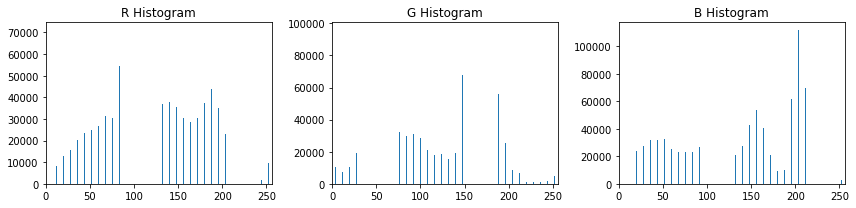

In [2]:
# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Take histograms in R, G, and B
    rhist = np.histogram(img[:,:,0], bins=32, range=(0, 256))
    ghist = np.histogram(img[:,:,1], bins=32, range=(0, 256))
    bhist = np.histogram(img[:,:,2], bins=32, range=(0, 256))
    # Generating bin centers
    bin_edges = rhist[1]
    bin_centers = (bin_edges[1:]  + bin_edges[0:len(bin_edges)-1])/2
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((rhist[0], ghist[0], bhist[0]))
    hist_features = np.ravel(hist_features)
    # Return the individual histograms, bin_centers and feature vector
    return rhist, ghist, bhist, bin_centers, hist_features
    
rh, gh, bh, bincen, feature_vec = color_hist(image, nbins=32, bins_range=(0, 256))

# Plot a figure with all three bar charts
if rh is not None:
    fig = plt.figure(figsize=(12,3))
    plt.subplot(131)
    plt.bar(bincen, rh[0])
    plt.xlim(0, 256)
    plt.title('R Histogram')
    plt.subplot(132)
    plt.bar(bincen, gh[0])
    plt.xlim(0, 256)
    plt.title('G Histogram')
    plt.subplot(133)
    plt.bar(bincen, bh[0])
    plt.xlim(0, 256)
    plt.title('B Histogram')
    fig.tight_layout()    
    plt.show()
else:
    print('Your function is returning None for at least one variable...')

In [3]:
#import Axes3D to plot 3D diagrams
from mpl_toolkits.mplot3d import Axes3D

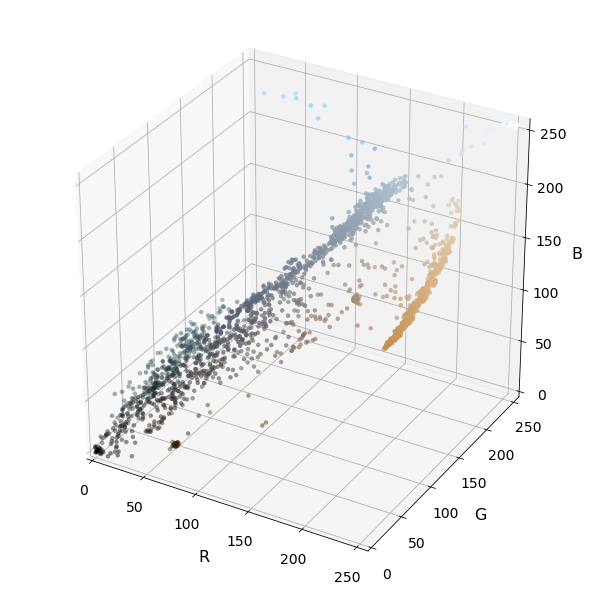

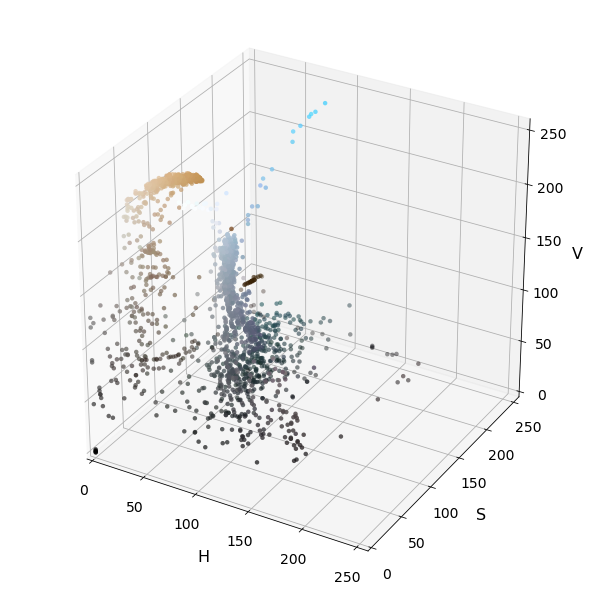

In [4]:
def plot3d(pixels, colors_rgb,
        axis_labels=list("RGB"), axis_limits=((0, 255), (0, 255), (0, 255))):
    #"""Plot pixels in 3D."""

    # Create figure and 3D axes
    fig = plt.figure(figsize=(8, 8))
    ax = Axes3D(fig)

    # Set axis limits
    ax.set_xlim(*axis_limits[0])
    ax.set_ylim(*axis_limits[1])
    ax.set_zlim(*axis_limits[2])

    # Set axis labels and sizes
    ax.tick_params(axis='both', which='major', labelsize=14, pad=8)
    ax.set_xlabel(axis_labels[0], fontsize=16, labelpad=16)
    ax.set_ylabel(axis_labels[1], fontsize=16, labelpad=16)
    ax.set_zlabel(axis_labels[2], fontsize=16, labelpad=16)

    # Plot pixel values with colors given in colors_rgb
    ax.scatter(
        pixels[:, :, 0].ravel(),
        pixels[:, :, 1].ravel(),
        pixels[:, :, 2].ravel(),
        c=colors_rgb.reshape((-1, 3)), edgecolors='none')

    return ax  # return Axes3D object for further manipulation

img = image
# Read a color image
#img = cv2.imread("000275.png")

# Select a small fraction of pixels to plot by subsampling it
scale = max(img.shape[0], img.shape[1], 64) / 64  # at most 64 rows and columns
img_small = cv2.resize(img, (np.int(img.shape[1] / scale), np.int(img.shape[0] / scale)), interpolation=cv2.INTER_NEAREST)

# Convert subsampled image to desired color space(s)
img_small_RGB = cv2.cvtColor(img_small, cv2.COLOR_BGR2RGB)  # OpenCV uses BGR, matplotlib likes RGB
img_small_HSV = cv2.cvtColor(img_small, cv2.COLOR_BGR2HSV)
img_small_rgb = img_small_RGB / 255.  # scaled to [0, 1], only for plotting

# Plot and show
plot3d(img_small_RGB, img_small_rgb)
plt.show()

plot3d(img_small_HSV, img_small_rgb, axis_labels=list("HSV"))
plt.show()

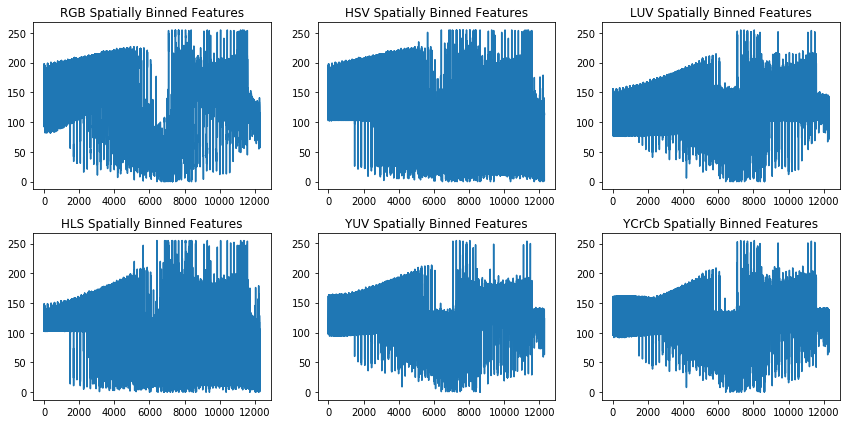

In [5]:
def bin_spatial(img, color_space='RGB', size = (32,32)):
    # Convert image to new color space (if specified)
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)             
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(feature_image, size).ravel() 
    # Return the feature vector
    return features
bin_size = (64,64)
#bin_size = (image.shape[0],image.shape[1])
feature_vec = bin_spatial(image, color_space='RGB', size = bin_size)
fig = plt.figure(figsize=(12,6))
plt.subplot(231)
plt.plot(bin_spatial(image, color_space='RGB', size = bin_size))
plt.title('RGB Spatially Binned Features')
plt.subplot(232)
plt.plot(bin_spatial(image, color_space='HSV', size = bin_size))
plt.title('HSV Spatially Binned Features')
plt.subplot(233)
plt.plot(bin_spatial(image, color_space='LUV', size = bin_size))
plt.title('LUV Spatially Binned Features')
plt.subplot(234)
plt.plot(bin_spatial(image, color_space='HLS', size = bin_size))
plt.title('HLS Spatially Binned Features')
plt.subplot(235)
plt.plot(bin_spatial(image, color_space='YUV', size = bin_size))
plt.title('YUV Spatially Binned Features')
plt.subplot(236)
plt.plot(bin_spatial(image, color_space='YCrCb', size = bin_size))
plt.title('YCrCb Spatially Binned Features')
fig.tight_layout()# Plot features
plt.show()

In [6]:
# Define a function to return some characteristics of the dataset 
def data_look(car_list, notcar_list):
    data_dict = {}
    # Define a key in data_dict "n_cars" and store the number of car images
    data_dict["n_cars"] = len(car_list)
    # Define a key "n_notcars" and store the number of notcar images
    data_dict["n_notcars"] = len(notcar_list)
    # Read in a test image, either car or notcar
    example_img = mpimg.imread(car_list[0])
    # Define a key "image_shape" and store the test image shape 3-tuple
    data_dict["image_shape"] = example_img.shape
    # Define a key "data_type" and store the data type of the test image.
    data_dict["data_type"] = example_img.dtype
    # Return data_dict
    return data_dict

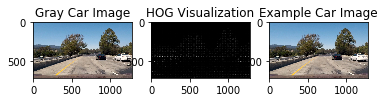

In [7]:

image = mpimg.imread('test_images/test1.jpg')
#Lecture 20
# Define HOG parameters
orient = 9
pix_per_cell = 8
cell_per_block = 2
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    if vis == True: # Call with two outputs if vis==True to visualize the HOG
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec,block_norm="L2-Hys")
        return features, hog_image
    else:      # Otherwise call with one output
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec,block_norm="L2-Hys")
        return features
# Define a function to return HOG features and visualization
#def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
#    if vis == True:
#        features, hog_image = hog(img, orientations=orient,
#                          pixels_per_cell=(pix_per_cell, pix_per_cell), 
#                          cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
#                          visualise=True, feature_vector=False,
#                          block_norm="L2-Hys")
#        return features, hog_image
#    else:
#        # Use skimage.hog() to get features only
#        features = hog(img, orientations=orient,
#                          pixels_per_cell=(pix_per_cell, pix_per_cell), 
#                          cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
#                          visualise=False, feature_vector=False,
#                          block_norm="L2-Hys")
#        return features

#i = cv2.resize(image,(64,64))
i = image
gray = cv2.cvtColor(i, cv2.COLOR_RGB2GRAY)
# Call our function with vis=True to see an image output
features, hog_image = get_hog_features(gray, orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)

# Plot the examples
fig = plt.figure(3)
plt.subplot(131)
plt.imshow(i)
plt.title('Gray Car Image')
plt.subplot(132)
plt.imshow(hog_image, cmap='gray')
plt.title('HOG Visualization')
plt.subplot(133)
plt.imshow(image)
plt.title('Example Car Image')
plt.show()

In [32]:
from sklearn.preprocessing import StandardScaler
def extract_features(imgs, cspace='RGB', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256), orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0, apply_bin = True, apply_hist = True, apply_hog = True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        image = cv2.resize(image, spatial_size)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      
        # Call get_hog_features() with vis=False, feature_vec=True
        i_features = []
        if apply_hog == True:
            if hog_channel == 'ALL':
                hog_features = []        
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            i_features.append(hog_features)
        if apply_bin == True:
            # Apply bin_spatial() to get spatial color features
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            i_features.append(spatial_features)
        #print(spatial_features.shape)
        # Apply color_hist() also with a color space option now
        if apply_hist == True:
            rh, gh, bh, bincen, hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
            i_features.append(hist_features)
        #print(hist_features.shape)
        # Append the new feature vector to the features list
        #print(len(spatial_features),len(hist_features))
        features.append(np.concatenate(i_features))
        #print(features[-1].shape)
    # Return list of feature vectors
    return features

In [9]:
import os.path
import pickle
def save_model(svc,X_scaler, file):
    model = (svc, X_scaler)
    # save the model to disk
    pickle.dump(model, open(file, 'wb'))
    return model
def load_model(file):
    if os.path.isfile(file):
        return pickle.load(open(file, 'rb'))
    else: return None

In [10]:
import sklearn
print("I am using : ",sklearn.__version__)
from sklearn.model_selection import train_test_split

I am using :  0.19.0


In [11]:
import time
def train_features(car_features, notcar_features, vis = False):
    if len(car_features) > 0 and len(notcar_features) > 0:
        # Create an array stack of feature vectors
        X = np.vstack((car_features, notcar_features)).astype(np.float64)  
        #X = v
        # Fit a per-column scalesr
        X_scaler = StandardScaler().fit(X)
        # Apply the scaler to X
        scaled_X = X_scaler.transform(X)
        # Define the labels vector
        y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

        car_ind = np.random.randint(0, len(cars))
        #print(cars[car_ind])
        if vis:
            # Plot an example of raw and scaled features
            fig = plt.figure(figsize=(12,3))
            plt.subplot(131)
            plt.imshow(mpimg.imread(cars[car_ind]))
            plt.title('Original Image')
            plt.subplot(132)
            plt.plot(X[car_ind])
            plt.title('Raw Features')
            plt.subplot(133)
            plt.plot(scaled_X[car_ind])
            plt.title('Normalized Features')
            fig.tight_layout()
            plt.show()
        else: 
            print('Your function only returns empty feature vectors...')
        
    # Split up data into randomized training and test sets
    rand_state = np.random.randint(0, 100)
    X_train, X_test, y_train, y_test = train_test_split(
        scaled_X, y, test_size=0.2, random_state=rand_state)

    print('Using spatial binning of:',spatial,
        'and', histbin,'histogram bins')
    print('Feature vector length:', len(X_train[0]))
    print('Train samples length:', len(X_train))
    print('Test samples length:', len(X_test))

    # Use a linear SVC 
    svc = LinearSVC()
    # Check the training time for the SVC
    t=time.time()
    svc.fit(X_train, y_train)
    t2 = time.time()
    print(round(t2-t, 2), 'Seconds to train SVC...')
    # Check the score of the SVC
    print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
    # Check the prediction time for a single sample
    t=time.time()
    n_predict = 10
    print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
    print('For these',n_predict, 'labels: ', y_test[0:n_predict])
    t2 = time.time()
    print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')
    return svc, X_scaler

1125
1125


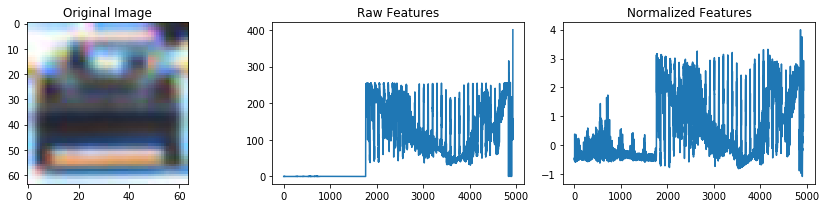

Using spatial binning of: 32 and 32 histogram bins
Feature vector length: 4932
Train samples length: 1800
Test samples length: 450
1.98 Seconds to train SVC...
Test Accuracy of SVC =  0.9867
My SVC predicts:  [ 0.  0.  1.  0.  1.  0.  0.  0.  0.  1.]
For these 10 labels:  [ 1.  0.  1.  0.  1.  0.  0.  0.  0.  1.]
0.001 Seconds to predict 10 labels with SVC


In [56]:
# performs under different binning scenarios
spatial = 32
histbin = 32
car_features = extract_features(cars, cspace='RGB', spatial_size=(spatial, spatial),
                        hist_bins=histbin, hist_range=(0, 256), orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0)
print(len(car_features))
notcar_features = extract_features(notcars, cspace='RGB', spatial_size=(spatial, spatial),
                        hist_bins=histbin, hist_range=(0, 256), orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0)
print(len(notcar_features))
svc, X_scaler = train_features(car_features, notcar_features, vis = True)

In [13]:
save_model(svc,X_scaler,'model.p')

(LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
      intercept_scaling=1, loss='squared_hinge', max_iter=1000,
      multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
      verbose=0), StandardScaler(copy=True, with_mean=True, with_std=True))

In [14]:
# Here is your draw_boxes function from the previous exercise
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

In [15]:
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list



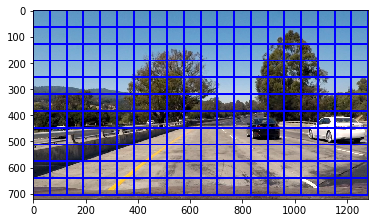

In [57]:
#image = mpimg.imread('test_images/test1.jpg')
windows = slide_window(image, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(128, 128), xy_overlap=(0.5, 0.5))
                       
window_img = draw_boxes(image, windows, color=(0, 0, 255), thick=6)                    
plt.imshow(window_img)

In [53]:
# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel='ALL',
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #print("Adding spatial features")
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        rh, gh, bh, bincen, hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        #print("Adding hist features")
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #print("Adding hog features")
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    print("Car found windows: ",len(on_windows)," out of ", len(windows))
    #8) Return windows for positive detections
    return on_windows
    

In [63]:
hog_channel='ALL'# Can be 0, 1, 2, or "ALL"
image2 = mpimg.imread('test_images/test1.jpg')
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [380, 720] # Min and max in y to search in slide_window()
iterations = 2
#hog_channel='ALL'
modelname = 'all_cars_model1.p'
model = load_model(modelname)
#if model is None:
all_car_features = extract_features(all_cars, cspace=color_space, spatial_size=spatial_size,
                        hist_bins=histbin, hist_range=(0, 256),hog_channel=hog_channel
                               , apply_bin = spatial_feat, apply_hist = hist_feat, apply_hog = hog_feat)
all_notcar_features = extract_features(all_notcars, cspace=color_space, spatial_size=spatial_size,
                        hist_bins=histbin, hist_range=(0, 256),hog_channel=hog_channel
                                   , apply_bin = spatial_feat, apply_hist = hist_feat, apply_hog = hog_feat)
for i in range(iterations):
    svc, X_scaler = train_features(all_car_features, all_notcar_features)
save_model(svc, X_scaler,modelname)
#else:
#    (svc, X_scaler) = model
#    print("Found saved model")

Your function only returns empty feature vectors...
Using spatial binning of: 32 and 32 histogram bins
Feature vector length: 6156
Train samples length: 14067
Test samples length: 3517
19.55 Seconds to train SVC...
Test Accuracy of SVC =  0.9829
My SVC predicts:  [ 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.]
For these 10 labels:  [ 0.  0.  0.  1.  0.  0.  0.  0.  1.  0.]
0.001 Seconds to predict 10 labels with SVC
Your function only returns empty feature vectors...
Using spatial binning of: 32 and 32 histogram bins
Feature vector length: 6156
Train samples length: 14067
Test samples length: 3517
19.27 Seconds to train SVC...
Test Accuracy of SVC =  0.9818
My SVC predicts:  [ 1.  0.  1.  0.  1.  1.  1.  0.  0.  1.]
For these 10 labels:  [ 1.  0.  1.  0.  1.  1.  1.  0.  0.  1.]
0.002 Seconds to predict 10 labels with SVC


(LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
      intercept_scaling=1, loss='squared_hinge', max_iter=1000,
      multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
      verbose=0), StandardScaler(copy=True, with_mean=True, with_std=True))

Car found windows:  62  out of  76


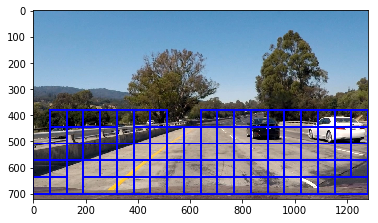

In [64]:
windows = slide_window(image2, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                    xy_window=(128, 128), xy_overlap=(0.5, 0.5))

hot_windows = search_windows(image2, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)                       

window_img = draw_boxes(image2, hot_windows, color=(0, 0, 255), thick=6)                    

plt.imshow(window_img)


In [65]:
def convert_color(img, color_space='RGB'):
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    return feature_image

((64, 380), (192, 508))


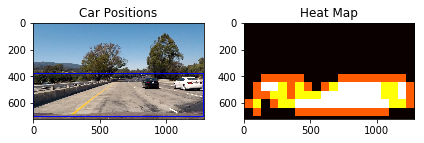

In [66]:
from scipy.ndimage.measurements import label
box_list = hot_windows
heat = np.zeros_like(image[:,:,0]).astype(np.float)
if box_list is not None and len(box_list) >0:
    print(box_list[0])
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

# Add heat to each box in box list
heat = add_heat(heat,box_list)
    
# Apply threshold to help remove false positives
heat = apply_threshold(heat,1)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(image), labels)

fig = plt.figure()
plt.subplot(121)
plt.imshow(draw_img)
plt.title('Car Positions')
plt.subplot(122)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
fig.tight_layout()


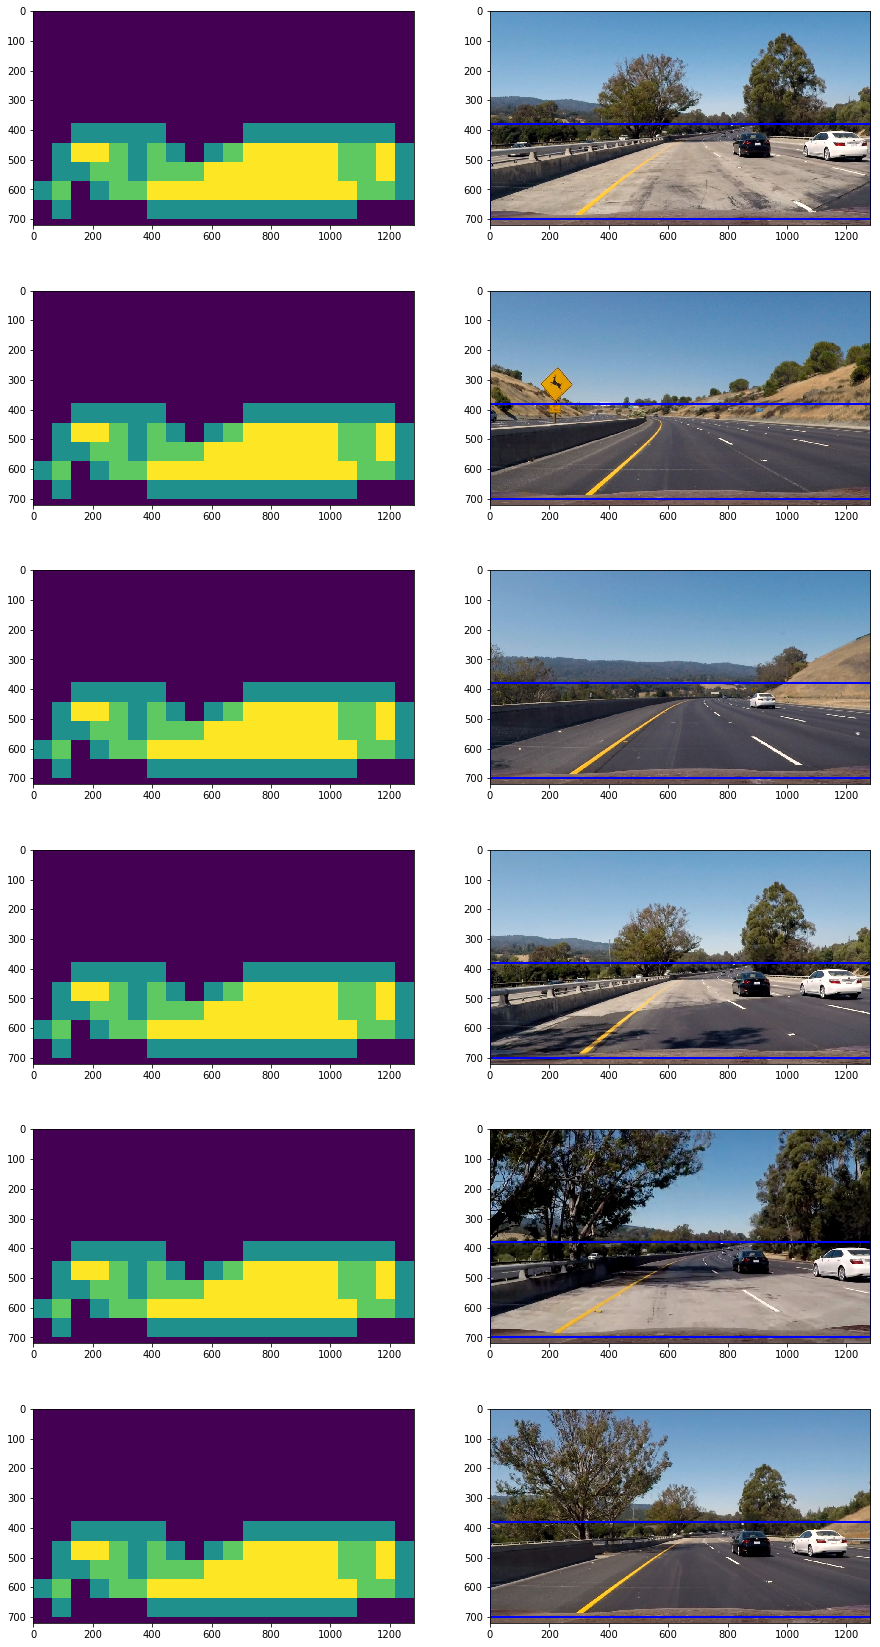

In [96]:
def plotImages(images, cols = 2, rows = 3):
    l = len(images)
    figsize = (15,30)
    rows = (int)(l / 2)
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    boxes = range(cols * rows)
    for ax, b in zip(axes.flat, boxes):
        if b < l:
            image = images[b]
            ax.imshow(image)
plotImages(test_out_imgs)


In [101]:
def pipeline(img):
    windows = slide_window(img, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                        xy_window=(128, 128), xy_overlap=(0.5, 0.5))

    hot_windows = search_windows(img, windows, svc, X_scaler, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)                       

    window_img = draw_boxes(img, hot_windows, color=(0, 0, 255), thick=6)                    

    heat = np.zeros_like(window_img[:,:,0]).astype(np.float)
    # Add heat to each box in box list
    heat = add_heat(heat,box_list)

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,1)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)
    #out_imgs.append(heatmap)
    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    label_img = draw_labeled_bboxes(np.copy(img), labels)
    return label_img
    

Car found windows:  62  out of  76
Car found windows:  61  out of  76
Car found windows:  58  out of  76
Car found windows:  52  out of  76
Car found windows:  57  out of  76
Car found windows:  61  out of  76


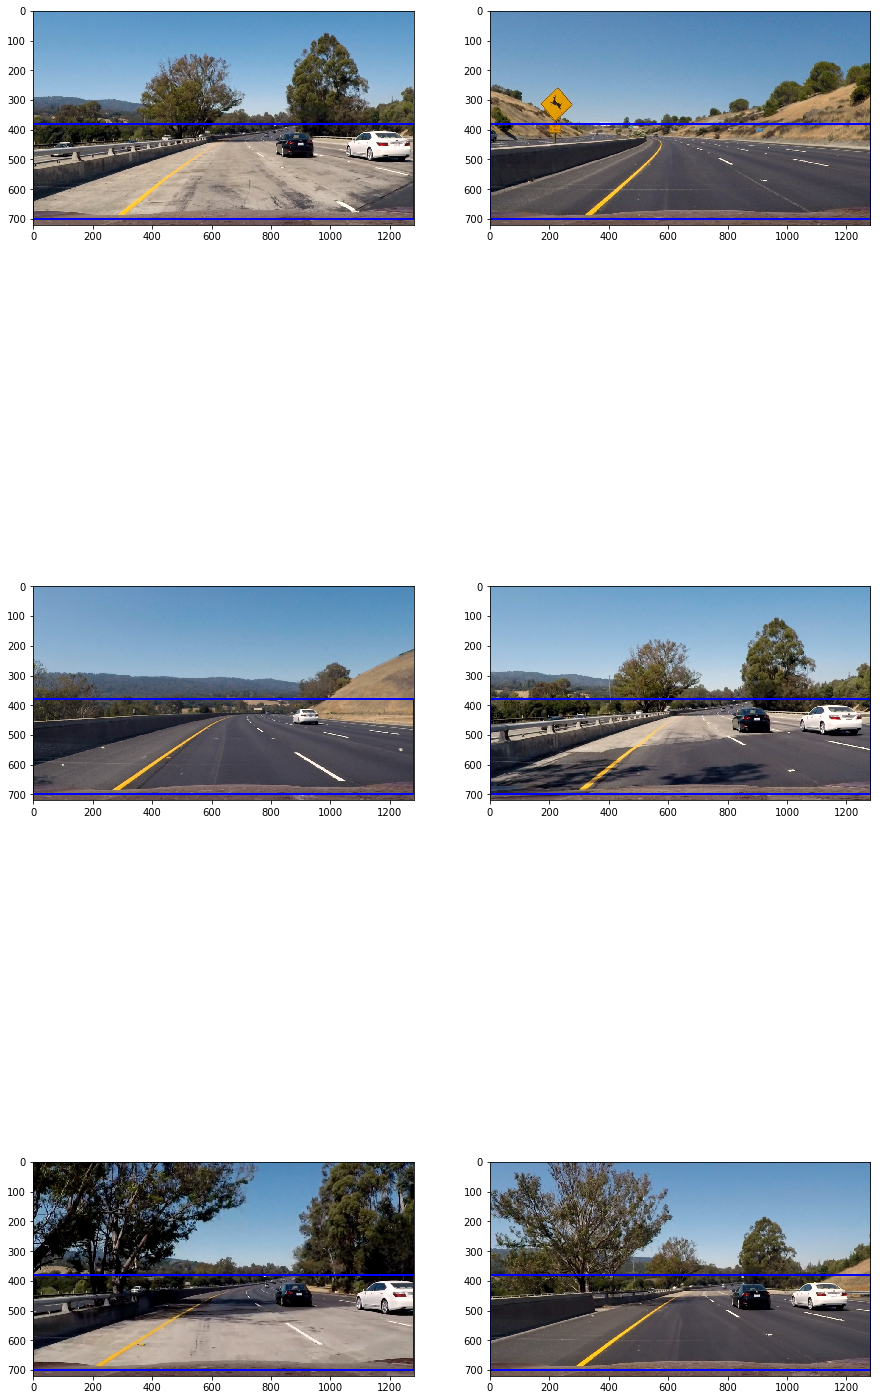

In [102]:
t_out_imgs = []
fig = plt.figure()
for i in range(len(test_imgs)):
    iname = test_imgs[i]
    img = mpimg.imread(iname)
    t_out_img = pipeline(img)
    t_out_imgs.append(t_out_img)
    fig.savefig('output_images/test'+ (str)(i+1) +'.jpg')
plotImages(t_out_imgs)

In [107]:

# If the input is the camera, pass 0 instead of the video file name
output_video = 'output_project_video.mp4'

clip = VideoFileClip("project_video.mp4").subclip(0,3)
output_clip = clip.fl_image(pipeline) #NOTE: this function expects color images!!
%time output_clip.write_videofile(output_video, audio=False)

Car found windows:  49  out of  76
[MoviePy] >>>> Building video output_project_video.mp4
[MoviePy] Writing video output_project_video.mp4



  0%|                                                   | 0/76 [00:00<?, ?it/s]

Car found windows:  49  out of  76



  1%|▌                                          | 1/76 [00:00<01:14,  1.01it/s]

Car found windows:  56  out of  76



  3%|█▏                                         | 2/76 [00:01<01:09,  1.07it/s]

Car found windows:  57  out of  76



  4%|█▋                                         | 3/76 [00:02<01:05,  1.11it/s]

Car found windows:  58  out of  76



  5%|██▎                                        | 4/76 [00:03<01:02,  1.16it/s]

Car found windows:  54  out of  76



  7%|██▊                                        | 5/76 [00:04<00:59,  1.19it/s]

Car found windows:  54  out of  76



  8%|███▍                                       | 6/76 [00:04<00:58,  1.20it/s]

Car found windows:  58  out of  76



  9%|███▉                                       | 7/76 [00:05<00:56,  1.22it/s]

Car found windows:  50  out of  76



 11%|████▌                                      | 8/76 [00:06<00:55,  1.22it/s]

Car found windows:  48  out of  76



 12%|█████                                      | 9/76 [00:07<00:54,  1.24it/s]

Car found windows:  45  out of  76



 13%|█████▌                                    | 10/76 [00:08<00:53,  1.23it/s]

Car found windows:  56  out of  76



 14%|██████                                    | 11/76 [00:08<00:52,  1.24it/s]

Car found windows:  50  out of  76



 16%|██████▋                                   | 12/76 [00:09<00:51,  1.24it/s]

Car found windows:  49  out of  76



 17%|███████▏                                  | 13/76 [00:10<00:50,  1.25it/s]

Car found windows:  51  out of  76



 18%|███████▋                                  | 14/76 [00:11<00:49,  1.26it/s]

Car found windows:  56  out of  76



 20%|████████▎                                 | 15/76 [00:12<00:49,  1.24it/s]

Car found windows:  49  out of  76



 21%|████████▊                                 | 16/76 [00:13<00:49,  1.21it/s]

Car found windows:  49  out of  76



 22%|█████████▍                                | 17/76 [00:13<00:48,  1.21it/s]

Car found windows:  47  out of  76



 24%|█████████▉                                | 18/76 [00:14<00:48,  1.19it/s]

Car found windows:  52  out of  76



 25%|██████████▌                               | 19/76 [00:15<00:48,  1.18it/s]

Car found windows:  54  out of  76



 26%|███████████                               | 20/76 [00:16<00:43,  1.29it/s]

Car found windows:  55  out of  76



 28%|███████████▌                              | 21/76 [00:16<00:41,  1.33it/s]

Car found windows:  52  out of  76



 29%|████████████▏                             | 22/76 [00:17<00:38,  1.41it/s]

Car found windows:  60  out of  76



 30%|████████████▋                             | 23/76 [00:18<00:35,  1.48it/s]

Car found windows:  54  out of  76



 32%|█████████████▎                            | 24/76 [00:18<00:34,  1.50it/s]

Car found windows:  53  out of  76



 33%|█████████████▊                            | 25/76 [00:19<00:33,  1.54it/s]

Car found windows:  52  out of  76



 34%|██████████████▎                           | 26/76 [00:20<00:32,  1.52it/s]

Car found windows:  55  out of  76



 36%|██████████████▉                           | 27/76 [00:20<00:31,  1.55it/s]

Car found windows:  53  out of  76



 37%|███████████████▍                          | 28/76 [00:21<00:30,  1.60it/s]

Car found windows:  51  out of  76



 38%|████████████████                          | 29/76 [00:21<00:29,  1.60it/s]

Car found windows:  52  out of  76



 39%|████████████████▌                         | 30/76 [00:22<00:28,  1.61it/s]

Car found windows:  54  out of  76



 41%|█████████████████▏                        | 31/76 [00:23<00:31,  1.43it/s]

Car found windows:  52  out of  76



 42%|█████████████████▋                        | 32/76 [00:24<00:30,  1.44it/s]

Car found windows:  54  out of  76



 43%|██████████████████▏                       | 33/76 [00:24<00:28,  1.49it/s]

Car found windows:  48  out of  76



 45%|██████████████████▊                       | 34/76 [00:25<00:26,  1.56it/s]

Car found windows:  54  out of  76



 46%|███████████████████▎                      | 35/76 [00:25<00:25,  1.61it/s]

Car found windows:  58  out of  76



 47%|███████████████████▉                      | 36/76 [00:26<00:24,  1.65it/s]

Car found windows:  56  out of  76



 49%|████████████████████▍                     | 37/76 [00:27<00:23,  1.63it/s]

Car found windows:  52  out of  76



 50%|█████████████████████                     | 38/76 [00:27<00:23,  1.63it/s]

Car found windows:  58  out of  76



 51%|█████████████████████▌                    | 39/76 [00:28<00:22,  1.66it/s]

Car found windows:  53  out of  76



 53%|██████████████████████                    | 40/76 [00:28<00:21,  1.68it/s]

Car found windows:  56  out of  76



 54%|██████████████████████▋                   | 41/76 [00:29<00:20,  1.70it/s]

Car found windows:  54  out of  76



 55%|███████████████████████▏                  | 42/76 [00:29<00:20,  1.68it/s]

Car found windows:  54  out of  76



 57%|███████████████████████▊                  | 43/76 [00:30<00:20,  1.63it/s]

Car found windows:  55  out of  76



 58%|████████████████████████▎                 | 44/76 [00:31<00:19,  1.62it/s]

Car found windows:  58  out of  76



 59%|████████████████████████▊                 | 45/76 [00:31<00:19,  1.61it/s]

Car found windows:  54  out of  76



 61%|█████████████████████████▍                | 46/76 [00:32<00:18,  1.64it/s]

Car found windows:  51  out of  76



 62%|█████████████████████████▉                | 47/76 [00:33<00:17,  1.63it/s]

Car found windows:  54  out of  76



 63%|██████████████████████████▌               | 48/76 [00:33<00:17,  1.63it/s]

Car found windows:  50  out of  76



 64%|███████████████████████████               | 49/76 [00:35<00:22,  1.18it/s]

Car found windows:  58  out of  76



 66%|███████████████████████████▋              | 50/76 [00:36<00:28,  1.09s/it]

Car found windows:  58  out of  76



 67%|████████████████████████████▏             | 51/76 [00:38<00:31,  1.27s/it]

Car found windows:  56  out of  76



 68%|████████████████████████████▋             | 52/76 [00:40<00:34,  1.43s/it]

Car found windows:  56  out of  76



 70%|█████████████████████████████▎            | 53/76 [00:42<00:37,  1.63s/it]

Car found windows:  54  out of  76



 71%|█████████████████████████████▊            | 54/76 [00:44<00:38,  1.76s/it]

Car found windows:  55  out of  76



 72%|██████████████████████████████▍           | 55/76 [00:46<00:38,  1.85s/it]

Car found windows:  47  out of  76



 74%|██████████████████████████████▉           | 56/76 [00:48<00:36,  1.81s/it]

Car found windows:  58  out of  76



 75%|███████████████████████████████▌          | 57/76 [00:49<00:31,  1.66s/it]

Car found windows:  51  out of  76



 76%|████████████████████████████████          | 58/76 [00:50<00:26,  1.45s/it]

Car found windows:  54  out of  76



 78%|████████████████████████████████▌         | 59/76 [00:51<00:22,  1.32s/it]

Car found windows:  51  out of  76



 79%|█████████████████████████████████▏        | 60/76 [00:52<00:19,  1.23s/it]

Car found windows:  57  out of  76



 80%|█████████████████████████████████▋        | 61/76 [00:53<00:17,  1.16s/it]

Car found windows:  56  out of  76



 82%|██████████████████████████████████▎       | 62/76 [00:54<00:15,  1.11s/it]

Car found windows:  59  out of  76



 83%|██████████████████████████████████▊       | 63/76 [00:55<00:13,  1.08s/it]

Car found windows:  53  out of  76



 84%|███████████████████████████████████▎      | 64/76 [00:56<00:12,  1.04s/it]

Car found windows:  49  out of  76



 86%|███████████████████████████████████▉      | 65/76 [00:57<00:11,  1.02s/it]

Car found windows:  52  out of  76



 87%|████████████████████████████████████▍     | 66/76 [00:58<00:10,  1.03s/it]

Car found windows:  50  out of  76



 88%|█████████████████████████████████████     | 67/76 [00:59<00:09,  1.01s/it]

Car found windows:  55  out of  76



 89%|█████████████████████████████████████▌    | 68/76 [01:00<00:08,  1.02s/it]

Car found windows:  52  out of  76



 91%|██████████████████████████████████████▏   | 69/76 [01:01<00:07,  1.04s/it]

Car found windows:  52  out of  76



 92%|██████████████████████████████████████▋   | 70/76 [01:02<00:06,  1.03s/it]

Car found windows:  57  out of  76



 93%|███████████████████████████████████████▏  | 71/76 [01:03<00:05,  1.03s/it]

Car found windows:  59  out of  76



 95%|███████████████████████████████████████▊  | 72/76 [01:04<00:03,  1.07it/s]

Car found windows:  60  out of  76



 96%|████████████████████████████████████████▎ | 73/76 [01:04<00:02,  1.21it/s]

Car found windows:  59  out of  76



 97%|████████████████████████████████████████▉ | 74/76 [01:05<00:01,  1.31it/s]

Car found windows:  60  out of  76



 99%|█████████████████████████████████████████▍| 75/76 [01:06<00:00,  1.38it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_project_video.mp4 

Wall time: 1min 6s
